In [1]:
%matplotlib inline
import grale.gridfunction as gf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = np.array([ [ 0, 0, 0, 0, 0 ],
                  [ 0, 1, 2, 3, 0 ],
                  [ 0, 4, 5, 6, 0 ], 
                  [ 0, 7, 8, 9, 0 ],
                  [ 0, 0, 0, 0, 0 ] ], dtype=np.double)
bl = [ 2,3 ]
tr = [ 10, 9 ]

In [3]:
def createThetaGrid(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [4]:
x0, x1 = -5, 15
y0, y1 = -7, 13
evalgrid = createThetaGrid([x0, y0], [x1, y1], 1024, 1024)

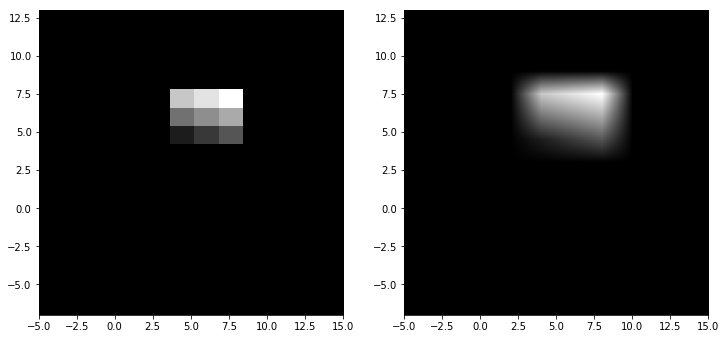

In [5]:
g = gf.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = 0)
g2 = gf.GridFunction(data, bl, tr, asPixels = False, rotationAngleRadians = 0)

vals = g.evaluate(evalgrid, False)
vals2 = g2.evaluate(evalgrid, False)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(vals2, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

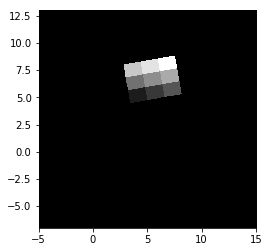

In [6]:
g = gf.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = np.pi/18)
vals = g.evaluate(evalgrid, False)
vals_A = vals

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

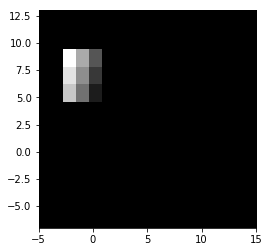

In [7]:
g = gf.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = 3.14/2)
vals = g.evaluate(evalgrid, False)

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

In [8]:
def rotate(v, a):
    return np.array([v[0]*np.cos(a) - v[1]*np.sin(a), v[0]*np.sin(a) + v[1]*np.cos(a)], dtype=np.double)

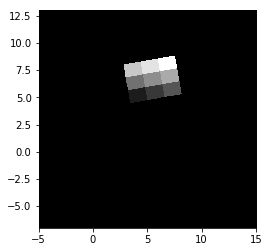

In [9]:
a = np.pi/18.0
p0 = np.array(bl, dtype=np.double)
p1 = p0 + rotate(np.array([tr[0]-bl[0], 0]), a)
p2 = p0 + rotate(np.array([0,tr[1]-bl[1]]), a)

g = gf.GridFunction.createFromCorners(data, p0, p1, p2, True)
vals = g.evaluate(evalgrid, False)

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

In [10]:
(vals-vals_A).min(), (vals-vals_A).max()

(0.0, 0.0)

In [11]:
from astropy.io import fits
from astropy import wcs
from grale.constants import *

In [12]:
f = fits.open("/home/jori/projects/graleeditor-hg/src/hlsp_frontier_hst_acs-60mas_abells1063_f814w_v1.0-epoch1_drz.fits")

In [13]:
f0 = f[0]
w = wcs.WCS(f0.header)
y, x = np.array(f0.data.shape)//2
center = np.array(w.all_pix2world(x, y, 0))*ANGLE_DEGREE

In [14]:
g = gf.GridFunction.createFromFITS(f0, center, True)

In [15]:
bl = np.array([-2, -2],dtype=np.double)*ANGLE_ARCSEC
tr = np.array([2, 2],dtype=np.double)*ANGLE_ARCSEC

evalgrid = createThetaGrid(bl, tr, 2048, 2048)

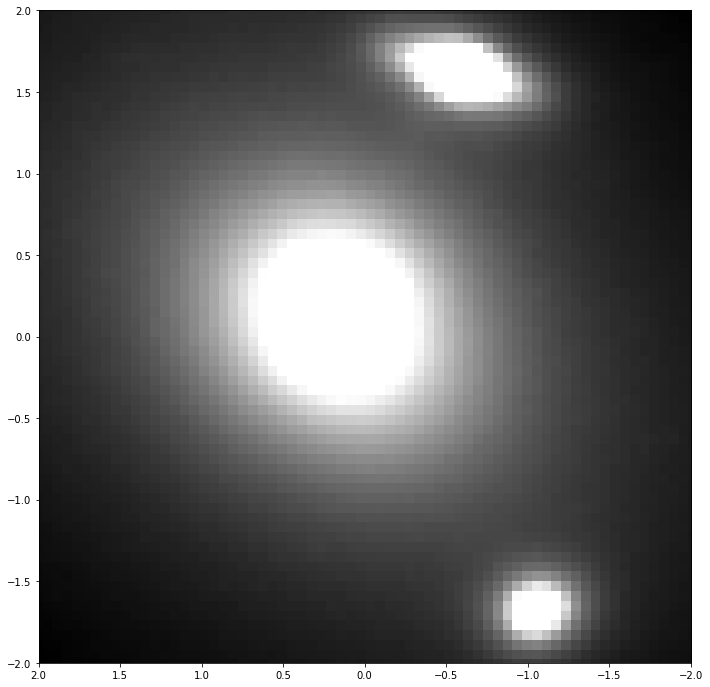

In [16]:
vals = g.evaluate(evalgrid, False)

plt.figure(figsize=(12,12))
plt.imshow(vals.clip(0,1), interpolation="none", extent = np.array([bl[0],tr[0],tr[1],bl[1]])/ANGLE_ARCSEC, cmap = "gray")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

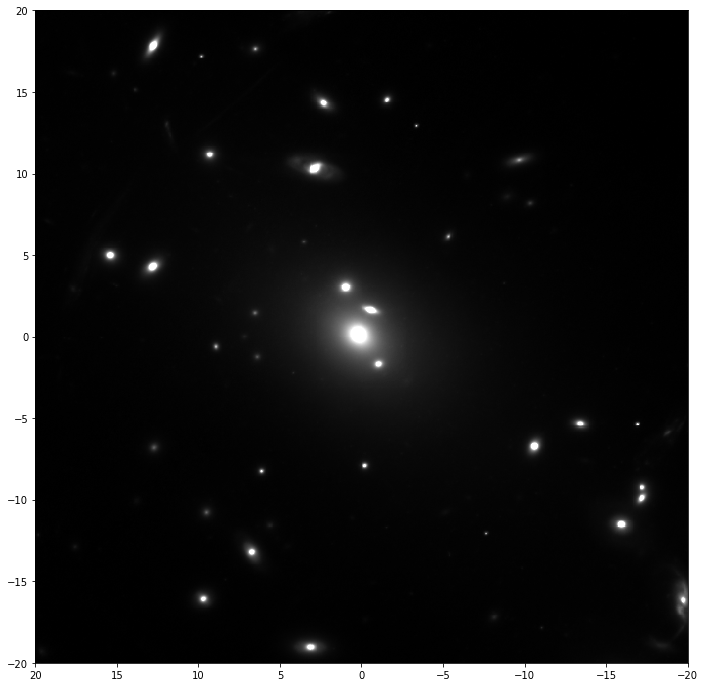

In [31]:
bl = np.array([-20, -20],dtype=np.double)*ANGLE_ARCSEC
tr = np.array([20, 20],dtype=np.double)*ANGLE_ARCSEC

evalgrid = createThetaGrid(bl, tr, 2048, 2048)
vals = g.evaluate(evalgrid, False)

plt.figure(figsize=(12,12))
plt.imshow(vals.clip(0,1), interpolation="none", extent = np.array([bl[0],tr[0],tr[1],bl[1]])/ANGLE_ARCSEC, cmap = "gray")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [32]:
import grale.grid as grid
import grale.plotutil as plotutil

In [33]:
cells = grid.createSubdivisionGridForFITS(f0, center, 20*ANGLE_ARCSEC, [0,0], 900, 1000)

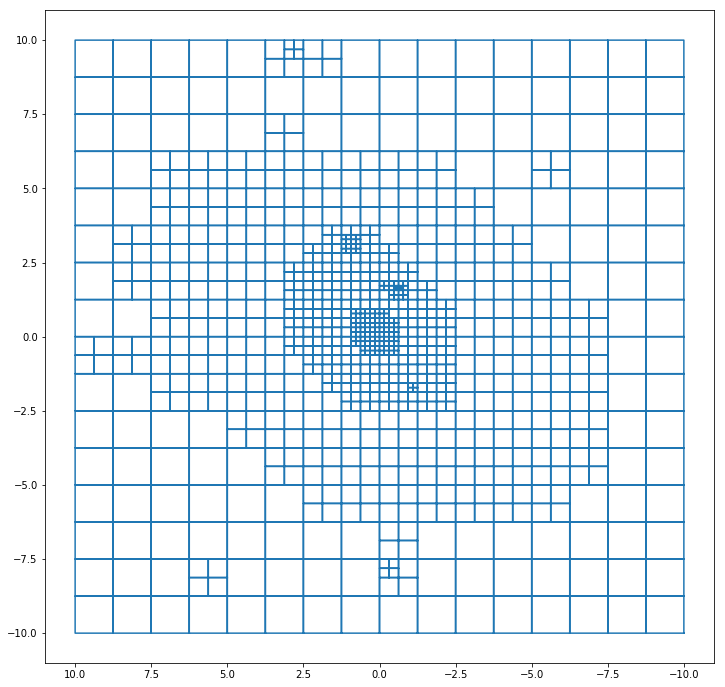

In [34]:
plt.figure(figsize=(12,12))
xp, yp = plotutil.plotSubdivisionGrid(cells, ANGLE_ARCSEC)
plt.gca().invert_xaxis()

In [35]:
Dd = 1000*DIST_MPC
l = grid.fitMultiplePlummerLens(cells, Dd, g.evaluate)

Text(value='')

FloatProgress(value=0.0)

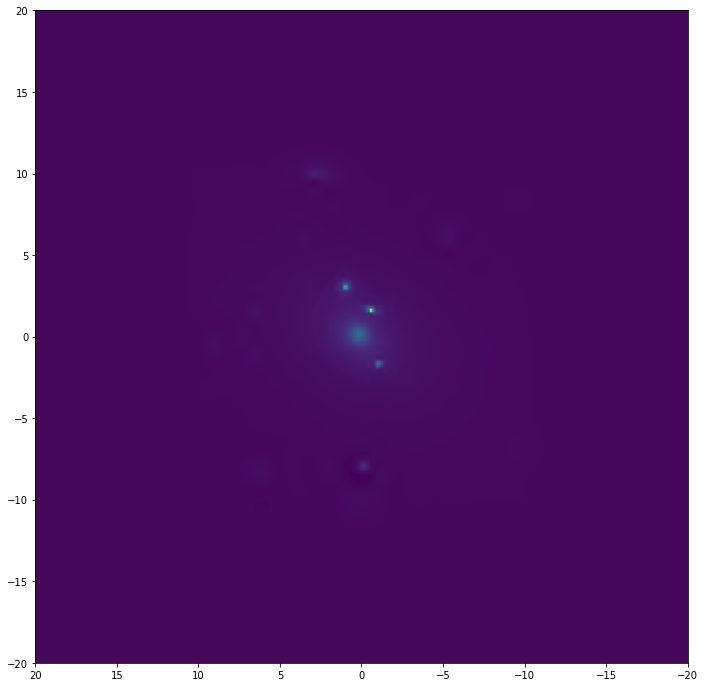

In [36]:
plt.figure(figsize=(12,12))
lensInfo = plotutil.plotDensity({ "lens": l, "bottomleft": bl, "topright": tr}, feedbackObject="notebook", 
                                angularUnit=ANGLE_ARCSEC, renderer="openmp");
plt.gca().invert_xaxis()

In [37]:
ec = [ 2*ANGLE_ARCSEC, 4*ANGLE_ARCSEC ]
es = 2.5*ANGLE_ARCSEC

def excludeFunction(c, s):
    if ( (c[0]+s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 and
         (c[0]-s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 and
         (c[0]+s/2-ec[0])**2 + (c[1]-s/2-ec[1])**2 < es**2 and
         (c[0]-s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 ):
        return True
    return False

cells = grid.createSubdivisionGridForFITS(f0, center, 20*ANGLE_ARCSEC, [0,0], 900, 1000, excludeFunction=excludeFunction)

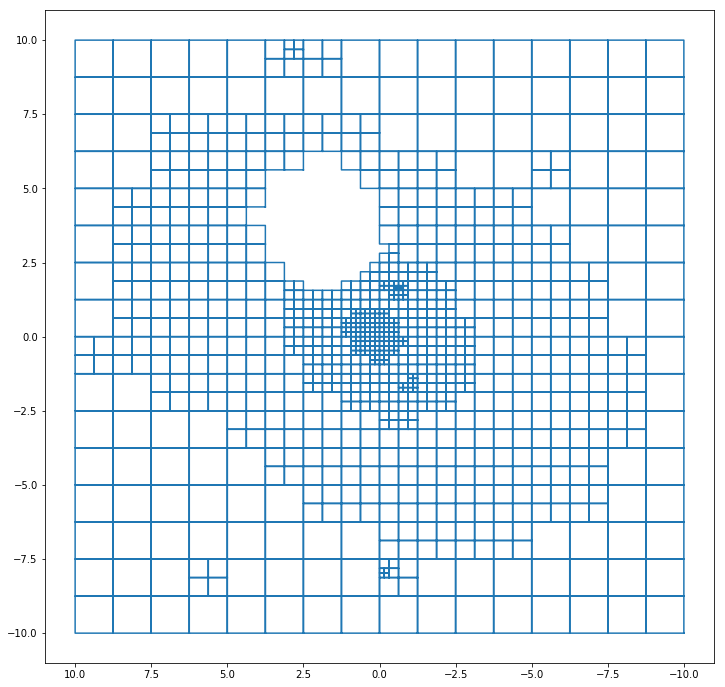

In [38]:
plt.figure(figsize=(12,12))
xp, yp = plotutil.plotSubdivisionGrid(cells, ANGLE_ARCSEC)
plt.gca().invert_xaxis()